# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

## Notes
We'll need to maintain a multioutput Gaussian Process surrogate for multifidelity Bayesian optimization. When using Gaussian Processes in the multifidelity scenario, one option is to extend the surrogate model through an autoregressive scheme:
$$
f^{(l)} = \rho f^{(l-1)}(\textbf{x}) + \delta^{l}(\textbf{x}), \;\; l = 2, \dots, L 
$$
where $\delta^{l}(\textbf{x}) \sim \mathcal{GP}(0, \kappa^{(l)}(\textbf{x}, \textbf{x}'))$ models the discrepancy between two adjoining levels of fidelity, and $\rho$ is a constant scaling factor.

## Desideratum
- [ ] We'll need a mechanism for computing covariances between input-fidelity pairs.
    - This poses a natural question: How do we choose our kernel function for evaluating the covariance between different fidelity levels?

## Minimal Problem Exploration
To make sense of the methodology presented in `Non-Myopic Multifidelity Bayesian Optimization`, we'll reduce our problem to the simplest instance of the generalized problem. That is, we only consider two fidelity measures via the autoregressive scheme:
$$
    f^{(2)} = \rho f^{(1)}(\textbf{x}) + \delta^{2}(\textbf{x})
$$

Given some arbitrary $\textbf{x}$, we know our 

## Surrogate and Kernel Setup

In [1]:
using Plots; plot() # warm start plotting engine
using LinearAlgebra
using Distributions

In [2]:
include("../src/testfns.jl")
include("../src/kernels.jl")
include("../src/surrogates.jl")

log_likelihood (generic function with 1 method)

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed.

Test Function: GramacyLee


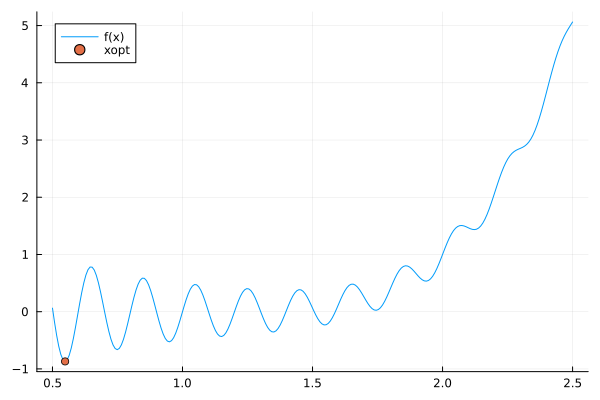

In [3]:
testfn, testfn_name, X, y = get_toy_problem(N=4, fn_name="GramacyLee")
println("Test Function: $(testfn_name)")
tplot(testfn)

In [4]:
kernel = SquaredExponential(.15)
sur = ZeroMeanGP(kernel, X, y, noise=1e-6);

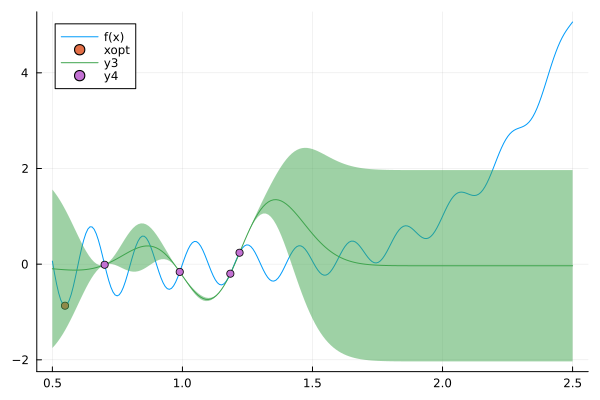

In [8]:
domain = first(testfn.bounds[:, 1]):.01:first(testfn.bounds[:, 2])
μ = [first(sur([x])) for x in domain]
σ = [sur([x])[2] for x in domain]

tplot(testfn)
plot!(domain, μ, ribbons=2σ)
scatter!(sur.X', get_observations(sur))

In [9]:
for _ in 1:50
    normal_sample = randn()
    plot!(domain, [([x], normal_sample) ~ sur for x in domain], label=nothing)
end

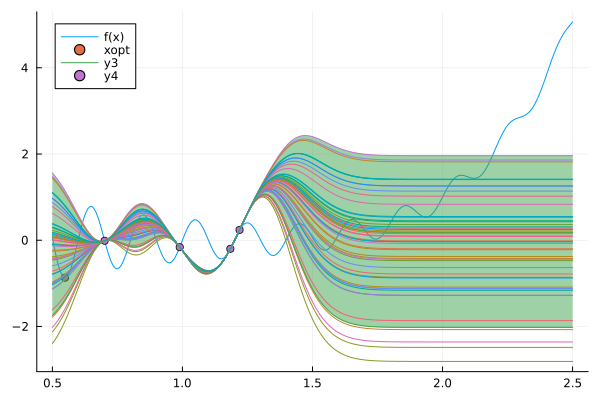

In [10]:
plot!()

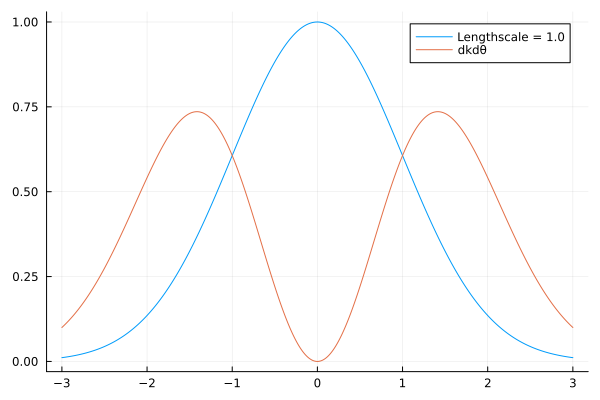

In [21]:
# Let's visualize several different initializations of the squared exponential
# kernel with different lengthscales
lengthscales = [1.]
kernels = [SquaredExponential(l) for l in lengthscales]
# gram_matrix(SquaredExponential(1.), X, noise=2.)
domain = -3.:.01:3.
dk = dkernel(SquaredExponential, lengthscales)

plot()
for (i, kernel) in enumerate(kernels)
    plot!(domain, [kernel([x], [0.]) for x in domain], label="Lengthscale = $(lengthscales[i])")
    plot!(domain, [first(dk([x], [0.])) for x in domain], label="dkdθ")
    # plot!(domain, [kernel([x], [0.]) - first(dk([x], [0.])) for x in domain], label="Δ")
end
plot!()

In [23]:
function UCB(sur::ZeroMeanGaussianProcess)
    function UCBx(x::AbstractVector; β=3.)
        μx, σx = sur(x)

        return μx + β*σx
    end

    return UCBx
end

UCB (generic function with 1 method)

In [41]:
kernel2 = Periodic(.87, 3.14)
sur2 = ZeroMeanGP(kernel2, X, y, noise=1e-6);

In [42]:
UCBx = UCB(sur)
UCBx2 = UCB(sur2)

UCBx (generic function with 1 method)

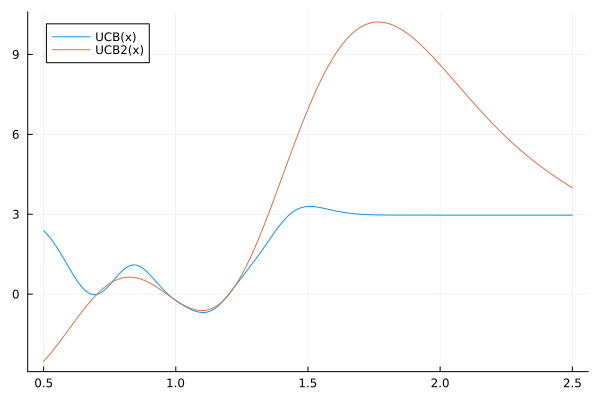

In [43]:
domain = first(testfn.bounds[:, 1]):.01:first(testfn.bounds[:, 2])

plot(domain, [UCBx([x]) for x in domain], label="UCB(x)")
plot!(domain, [UCBx2([x]) for x in domain], label="UCB2(x)")

## Delete Below

In [13]:
using ForwardDiff

In [14]:
ForwardDiff.gradient

gradient (generic function with 4 methods)

In [15]:
function SquaredExponential(lengthscales::AbstractVector)
    function squared_exponential(x, y)
        M = Diagonal(lengthscales .^ -2)
        r = x - y
        d = dot(r', M, r)
        return exp(-.5d)
    end

    return Kernel(lengthscales, squared_exponential)
end

SquaredExponential (generic function with 2 methods)

In [16]:
θs = [1.]

function dkernel(k_constructor::Function, θ::AbstractVector)
    ∇θ_ψ(x, y) = ForwardDiff.gradient(θ -> k_constructor(θ)(x, y), θ)
    
    return ∇θ_ψ
end

dkernel (generic function with 1 method)

In [17]:
dkernel(SquaredExponential, θs)([1.], [1.1])

1-element Vector{Float64}:
 0.009950124791926841